<a href="https://colab.research.google.com/github/JulioDuarte24/FC_CAIXAVERSO_ML1/blob/main/Aula2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 2 — Notebook Prático com Titanic  
**Tema:** Pré-processamento de dados  
**Objetivo:** Mostrar passo a passo, como preparar os dados antes de treinar modelos.

## 1) Importação de bibliotecas

In [ ]:
import matplotlib.pyplot as plt  # biblioteca para gráficos básicos
import seaborn as sns  # biblioteca que facilita acesso a datasets e gráficos
import pandas as pd  # biblioteca para manipulação de tabelas (dataframes)

# Ferramentas do scikit-learn para treino/teste e pré-processamento
from sklearn.model_selection import train_test_split  # separa treino e teste

from sklearn.impute import SimpleImputer  # imputação de valores faltantes
from sklearn.pipeline import Pipeline  # encadeia etapas de pré-processamento +
from sklearn.preprocessing import OneHotEncoder, StandardScaler  # encoding e escalonamento
from sklearn.compose import ColumnTransformer  # aplica transformações diferentes em colunas distintas

In [ ]:
def plotar_distribuicao(df, atributo):
  plt.hist(df[atributo].dropna(), bins=30)  # histograma (removendo NaN)
  plt.title(f"Distribuição {atributo}")  # título
  plt.xlabel(f'{atributo}')  # rótulo eixo x
  plt.ylabel("Frequência")  # rótulo eixo y

  plt.tight_layout()  # ajusta layout
  plt.show()  # exibe gráficos

In [ ]:
from sklearn.linear_model import LogisticRegression  # modelo simples de classificação
from sklearn.metrics import accuracy_score  # métricas

def regressao_logistica(X_treino, X_teste, y_treino, y_teste):
  modelo = LogisticRegression(max_iter=1000)  # cria modelo de regressão logística
  modelo.fit(X_treino, y_treino)  # treina modelo nos dados de treino
  y_pred = modelo.predict(X_teste)  # faz previsões no teste

  print("Acurácia:", accuracy_score(y_teste, y_pred))  # mede acurácia

## 2) Carregar o dataset Titanic

In [ ]:
dados = sns.load_dataset("titanic")  # carrega o dataset Titanic já incluso no seaborn
print("Formato da tabela:", dados.shape)  # mostra linhas e colunas
dados.head()  # mostra as 5 primeiras linhas da tabela

Formato da tabela: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


## 3) Exploração rápida (EDA)

In [ ]:
faltantes = dados.isna().sum().sort_values(ascending=False)  # conta valores faltantes por coluna
faltantes.head()  # exibe as 5 colunas com mais faltantes

,0
deck,688
age,177
embarked,2
embark_town,2
sex,0


In [ ]:
dados.dtypes  # mostra os tipos de dados (numérico, categórico, etc.)

,0
survived,int64
pclass,int64
sex,object
age,float64
sibsp,int64
parch,int64
fare,float64
embarked,object
class,category
who,object


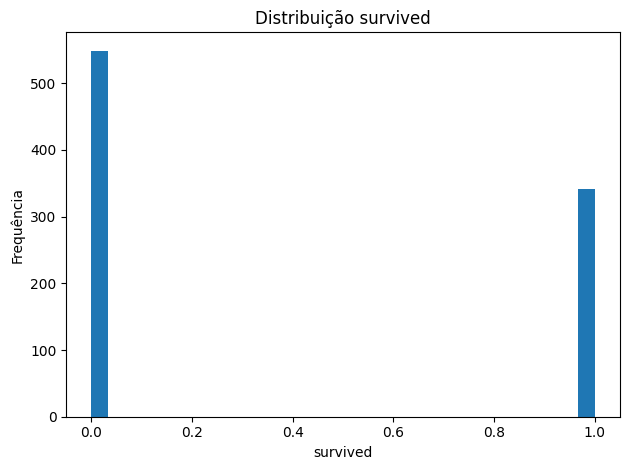

In [ ]:
plotar_distribuicao(dados,'survived')

In [ ]:
pd.crosstab(dados["sex"], dados["survived"], margins=True)  # tabela cruzada: sexo x sobreviveu

survived,0,1,All
sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


## 4) Definir variáveis explicativas (features) e alvo

In [ ]:
alvo = "survived"  # variável alvo é quem sobreviveu (0 = não, 1 = sim)

colunas_numericas = ["age", "fare", "sibsp", "parch"]  # colunas numéricas escolhidas
colunas_categoricas = ["sex", "embarked", "class"]  # colunas categóricas escolhidas

dados_modelo = dados.dropna(subset=[alvo]).copy()  # remove linhas onde o alvo é nulo

X = dados_modelo[colunas_numericas + colunas_categoricas]  # define as variáveis explicativas
y = dados_modelo[alvo].astype(int)  # define o alvo e garante que seja inteiro

X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y  # separa 80% treino, 20% teste, mantendo proporção de classes
)

print("Treino:", X_treino.shape, "| Teste:", X_teste.shape)  # mostra quantas linhas em treino e teste

Treino: (712, 7) | Teste: (179, 7)


## 5) Abordagem A (ingênua): sem pré-processamento

In [ ]:
XA_treino = X_treino[colunas_numericas].dropna(how="any").copy()  # usa apenas colunas numéricas e remove linhas com NaN
#XA_treino = X_treino[colunas_numericas].copy()
yA_treino = y_treino.loc[XA_treino.index]  # alinha alvo às linhas restantes

XA_teste = X_teste[colunas_numericas].dropna(how="any").copy()  # mesmo processo no conjunto de teste
yA_teste = y_teste.loc[XA_teste.index]  # alinha alvo

regressao_logistica(XA_treino, XA_teste, yA_treino, yA_teste)  # treina e avalia modelo

Acurácia: 0.6474820143884892


## 6) Abordagem B (correta): com pré-processamento (Pipeline)

In [ ]:
# Define pipeline para colunas numéricas: imputar média + escalar
transformador_numerico =
Pipeline(
    steps=[
          ("imputador", SimpleImputer(strategy="mean")),  # preenche faltantes com média
          ("escalonador", StandardScaler())  # coloca média=0 e desvio=1
    ]
  )

# Define pipeline para colunas categóricas: imputar moda + OneHot
transformador_categorico = Pipeline(steps=[
    ("imputador", SimpleImputer(strategy="most_frequent")),  # preenche faltantes com valor mais frequente
    ("onehot", OneHotEncoder(handle_unknown="ignore"))  # converte categorias em colunas binárias
])

# Aplica transformadores em colunas diferentes
pre_processador = ColumnTransformer(transformers=[
    ("num", transformador_numerico, colunas_numericas),  # aplica transformações numéricas
    ("cat", transformador_categorico, colunas_categoricas)  # aplica transformações categóricas
])

# Cria pipeline completo (pré-processamento + modelo)
pipeline_B = Pipeline(steps=[
    ("pre", pre_processador)])

# Aplica as transformações nos dados de treino
X_treino_processado = pipeline_B.fit_transform(X_treino)

# Para o teste, usamos apenas `.transform`, nunca `.fit_transform`
# Isso garante que as mesmas regras de transformação do treino sejam usadas no teste
X_teste_processado = pipeline_B.transform(X_teste)

# Chama sua função com os dados processados
regressao_logistica(X_treino_processado, X_teste_processado, y_treino, y_teste)


Acurácia: 0.7988826815642458


In [ ]:
pipeline_B

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputador',
                                                                   SimpleImputer()),
                                                                  ('escalonador',
                                                                   StandardScaler())]),
                                                  ['age', 'fare', 'sibsp',
                                                   'parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputador',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'embarked',
                                                   'class'])]))])

## 7) Conclusões

- Sem pré-processamento, **perdemos dados** e ignoramos variáveis categóricas importantes.  
- Com pipeline, **tratamos faltantes**, **transformamos texto em números** e **escalonamos** variáveis.  
- O **mesmo modelo** (LogisticRegression) performa melhor quando os dados são preparados corretamente.  
- Pré-processamento é um **passo obrigatório** antes de modelagem.